In [1]:
import gc

import numpy as np
import pandas as pd
import statsmodels.api as sm
import statsmodels.formula.api as smf
import matplotlib.pyplot as plt
import seaborn as sns
import scipy as sp
from scipy import stats
from datetime import  datetime, timedelta
from sklearn.preprocessing import StandardScaler

# 数据准备

In [2]:
# 数据准备
path1 = "D:/317research/317研究组/4 居住自选择/data/final_data/all_data/filled_data.csv"
data = pd.read_csv(path1)
data['who'] = data['who'].astype(int)

# 导入建成环境变量
path2 = "D:/317research/317研究组/4 居住自选择/data/BE_varis.csv"
be_varie = pd.read_csv(path2)
path3 = "D:/317research/317研究组/4 居住自选择/data/final_data/all_data/resident_info.csv"
resi_info = pd.read_csv(path3)
# 加入天气状况信息
path4 = "D:/317research/317研究组/4 居住自选择/data/weather_info.csv"
weather = pd.read_csv(path4)

In [3]:
data.head()

,date,who,sum_dist,metro_dist,metro_dist_ratio,walk_dist,walk_dist_ratio,chain_complexity,gender,age,T,move_time,P,move,holiday,weekday
0,20190101,6717,21540.0,0.0,0.0,0.0,0.000000,2.0,0,8.0,1,151,0,0,1,1
1,20190102,6717,32521.0,0.0,0.0,0.0,0.000000,4.0,0,8.0,2,151,0,0,0,2
2,20190103,6717,48364.0,0.0,0.0,0.0,0.000000,6.0,0,8.0,3,151,0,0,0,3
3,20190104,6717,20322.0,0.0,0.0,2263.0,0.111357,2.0,0,8.0,4,151,0,0,0,4
4,20190105,6717,39216.0,0.0,0.0,0.0,0.000000,2.0,0,8.0,5,151,0,0,1,5


<Axes: xlabel='age', ylabel='Count'>

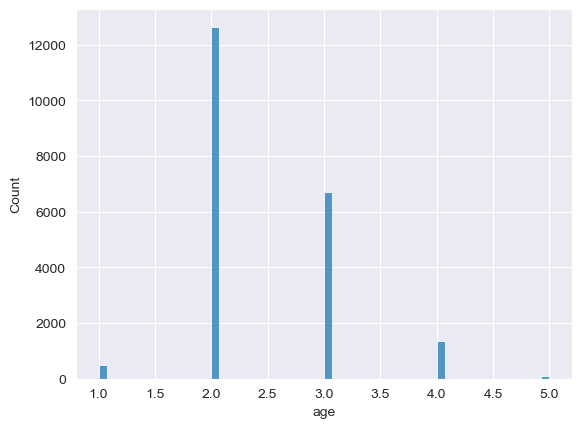

In [3]:
# 先给age重新分组
data['age'] = pd.cut(data['age'],bins=[0, 5, 7, 10, 14, float('inf')],labels=['Teenager', 'YoungAdult', 'Adult', 'MiddleElder', 'Elder'], right=False, ordered=False)
# 定义类别到数值的映射
age_mapping = {'Teenager': 1, 'YoungAdult': 2, 'Adult': 3, 'MiddleElder': 4, 'Elder': 5}
# 将类别替换为对应的数值
data['age'] = data['age'].map(age_mapping)
data['age'] = data['age'].astype(int)

sns.histplot(data[['who','age']].drop_duplicates()['age'])

In [4]:
# 特征数据
features = pd.merge(resi_info,be_varie,on='fnid',how='left')
features = features.drop(['row','column'],axis=1)
features.rename(columns={'date':'yearmonth'},inplace=True)
# 对work_dist一列的缺失值以0填充
features['work_dist'] = features['work_dist'].fillna(0)
features.head()

,who,yearmonth,fnid,group_id,move_dist,work_dist,density,landusemix,openratio_wide,intersections,...,dock,coach,eat,shop,hosp,subway,bus,edu,married,rent
0,68388056,20190101,38219,1,0.000000,5.280573,22.899753,0.611653,0.004943,14.222222,...,23.644266,0.040053,154.666667,279.111111,17.777778,0.000000,1.777778,0.059735,0.420117,1.968875
1,68229702,20191101,20076,2,8.657041,15.100863,30.440739,0.679730,0.090957,48.000000,...,12.549445,2.726802,142.222222,369.777778,65.777778,1.777778,10.666667,0.329922,0.516232,3.754838
2,68176269,20190701,23959,2,10.720544,20.660520,52.334233,0.622178,0.296840,12.444444,...,20.020197,0.604807,224.000000,368.000000,21.333333,0.000000,1.777778,0.026876,0.380712,1.766597
3,67686406,20190601,36512,2,7.318999,0.000000,49.070150,0.744327,0.068630,37.333333,...,27.033821,2.312159,528.000000,1317.333333,88.888889,0.000000,8.888889,0.029885,0.404828,1.945102
4,67656950,20190501,30376,1,0.000000,1.767251,17.133594,0.671043,0.049394,26.666667,...,23.518726,0.085487,254.222222,410.666667,35.555556,0.000000,7.111111,0.322048,0.311843,1.615556


## 建成环境变化量计算

In [5]:
be_list = ['density', 'landusemix', 'openratio_wide', 'road_density', 'intersections', 'center', 'subway','bus']
features = features[features['group_id']!=-1]
features_group = features.groupby(['who','group_id'])[be_list].mean().reset_index()

In [6]:
# 计算每个who的两组建成环境的相对变化量
relative_changes = []
for who in features_group['who'].unique():
    df_who = features_group[features_group['who'] == who]
    group1 = df_who[df_who['group_id'] == 1]
    group2 = df_who[df_who['group_id'] == 2]
    
    # Calculate relative change
    # change = np.abs(group2[be_list].values - group1[be_list].values) / \
    #          ((group1[be_list].values + group2[be_list].values) / 2)
    change = group2[be_list].values - group1[be_list].values
    # 如果是‘subway’，那么直接计算绝对变化，否则计算相对变化
    # change = np.zeros((1, len(be_list)))
    # # Calculate changes for each feature
    # for i, feature in enumerate(be_list):
    #     if (feature != 'subway') or (feature != 'bus') :
    #         # Calculate relative change
    #         change[0, i] = (group2[feature].values - group1[feature].values) / group1[feature].values
    #     else:
    #         # Calculate absolute change for subway
    #         change[0, i] = group2[feature].values - group1[feature].values
    
    change = change.flatten()
    relative_changes.append(change)

# Create a dataframe for relative changes
relative_changes_df = pd.DataFrame(
    relative_changes,
    columns = [be + '_change' for be in be_list]
)
relative_changes_df['who'] = features_group['who'].unique()

In [17]:
relative_changes_df.head()

,density_change,landusemix_change,road_density_change,intersections_change,center_change,subway_change,bus_change,who
0,-8.919340,-0.114394,0.625422,-24.939683,2.283825,-0.355556,-4.673016,6717
1,-75.853522,0.037434,3.305185,4.148148,-0.703601,0.395062,-4.049383,9226
2,3.001594,-0.107603,-31.856000,-27.555556,-4.972195,0.000000,-2.666667,9856
3,-20.074909,0.041895,-2.522370,23.703704,-1.733366,1.777778,20.148148,10560
4,-37.268282,-0.011511,-2.986370,-13.925926,7.054802,0.000000,5.037037,11694


## 建成环境特征合并

In [7]:
# 建成环境特征合并
be_varies_name = be_varie.columns[3:].tolist()
be_info = features[features['group_id']!=-1]
be_info_group = be_info.groupby(['who','group_id']).mean().reset_index()
be_info_group['move'] = be_info_group['group_id'] - 1  # 方便合并

# 将be数据加入到filled_data中
# data = pd.merge(data,be_info_group[['who','move']+be_varies_name],on=['who','move'],how='left')

# 修改为只加入搬家前的建成环境变量作为基准（搬家前建成环境 + 变化量 = 搬家后建成环境）
be_info_group = be_info_group[be_info_group['move']==0]
data = pd.merge(data,be_info_group[['who']+be_varies_name],on=['who'],how='left')

# 将move_dist和work_dist加入到data中
data = pd.merge(data,be_info_group[['who','move','move_dist','work_dist']],on=['who','move'],how='left')

In [8]:
# 缺失值用邻近数值填充
data['move_dist'] = data['move_dist'].fillna(method='ffill')
data['work_dist'] = data['work_dist'].fillna(method='ffill')
data.isnull().sum()

date                      0
who                       0
sum_dist                  0
metro_dist          3496199
metro_dist_ratio          0
walk_dist                 0
walk_dist_ratio     3497799
chain_complexity          0
gender                    0
age                       0
T                         0
move_time                 0
P                         0
move                      0
holiday                   0
weekday                   0
density                   0
landusemix                0
openratio_wide            0
intersections             0
road_density              0
center                    0
airport                   0
railway                   0
dock                      0
coach                     0
eat                       0
shop                      0
hosp                      0
subway                    0
bus                       0
edu                       0
married                   0
rent                      0
move_dist                 0
work_dist           

In [9]:
# 加入建成环境变化量数据
data = pd.merge(data,relative_changes_df,on='who',how='left')
data.isnull().sum()

date                           0
who                            0
sum_dist                       0
metro_dist               3496199
metro_dist_ratio               0
walk_dist                      0
walk_dist_ratio          3497799
chain_complexity               0
gender                         0
age                            0
T                              0
move_time                      0
P                              0
move                           0
holiday                        0
weekday                        0
density                        0
landusemix                     0
openratio_wide                 0
intersections                  0
road_density                   0
center                         0
airport                        0
railway                        0
dock                           0
coach                          0
eat                            0
shop                           0
hosp                           0
subway                         0
bus       

In [10]:
# 加入天气状况信息
data = pd.merge(data,weather,on='date',how='left')

In [12]:
data.isnull().sum()

date                           0
who                            0
sum_dist                       0
metro_dist               3496199
metro_dist_ratio               0
walk_dist                      0
walk_dist_ratio          3497799
chain_complexity               0
gender                         0
age                            0
T                              0
move_time                      0
P                              0
move                           0
holiday                        0
weekday                        0
density                        0
landusemix                     0
openratio_wide                 0
intersections                  0
road_density                   0
center                         0
airport                        0
railway                        0
dock                           0
coach                          0
eat                            0
shop                           0
hosp                           0
subway                         0
bus       

In [11]:
len(data)/len(data['who'].unique())

365.0

In [8]:
data.to_csv("D:/317研究组/4 居住自选择/data/final_data/all_data/all_data.csv",index=False)

In [21]:
# 查看features的平均值、标准差等情况
features.describe()

,who,yearmonth,fnid,group_id,move_dist,work_dist,density,landusemix,openratio_wide,intersections,...,dock,coach,eat,shop,hosp,subway,bus,edu,married,rent
count,2.506210e+05,2.506210e+05,250621.000000,250621.000000,250621.000000,250621.000000,250621.000000,250621.000000,250621.000000,250621.000000,...,250621.000000,250621.000000,250621.000000,250621.000000,250621.000000,250621.000000,250621.000000,250621.000000,250621.000000,250621.000000
mean,3.963587e+07,2.019065e+07,27930.035516,1.487936,6.332544,4.973003,36.658191,0.668087,0.087719,32.040743,...,23.229572,1.372447,336.332945,570.956664,50.855011,0.480701,7.798313,0.146986,0.435596,4.024912
std,2.285707e+07,3.442076e+02,11913.336713,0.519006,9.168981,7.197790,26.232545,0.090936,0.121536,25.321100,...,12.278080,1.324988,272.273620,459.273834,39.776159,0.851572,4.598966,0.117920,0.121525,3.309272
min,6.717000e+03,2.019010e+07,2913.000000,-1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.761134
25%,2.003285e+07,2.019040e+07,18286.000000,1.000000,0.000000,0.000000,15.314496,0.621022,0.009437,14.222222,...,12.661637,0.243891,120.888889,197.333333,17.777778,0.000000,5.333333,0.044531,0.370855,2.104711
50%,3.953283e+07,2.019070e+07,26213.000000,1.000000,0.000000,1.735998,32.084713,0.679632,0.043109,26.666667,...,23.135060,1.044332,270.222222,460.444444,42.666667,0.000000,7.111111,0.121284,0.454343,3.169537
75%,5.955890e+07,2.019100e+07,36529.000000,2.000000,9.946475,7.832541,54.022182,0.729671,0.113256,42.666667,...,29.763525,2.112411,503.111111,855.111111,76.444444,1.777778,10.666667,0.227313,0.522072,4.776315
max,7.896523e+07,2.019120e+07,62880.000000,2.000000,67.838613,68.489213,148.874853,0.936289,0.998199,192.000000,...,81.009015,17.694606,1964.444444,3297.777778,204.444444,5.333333,42.666667,0.662490,0.781939,56.048926


# 特征选取

In [7]:
from sklearn.model_selection import train_test_split
from sklearn.feature_selection import SelectKBest, f_regression, mutual_info_regression

In [8]:
def select_features(X_train, y_train, X_test):
    fs = SelectKBest(score_func=f_regression, k='all')
    fs.fit(X_train, y_train)
    X_train_fs = fs.transform(X_train)
    X_test_fs = fs.transform(X_test)
    return X_train_fs, X_test_fs, fs

Feature density: 272.931561
Feature landusemix: 216.737765
Feature openratio_wide: 7.569286
Feature intersections: 476.283443
Feature road_density: 500.194751
Feature center: 782.706465
Feature airport: 48.934640
Feature railway: 13.876326
Feature dock: 32.568368
Feature coach: 190.644857
Feature eat: 733.350776
Feature shop: 225.123420
Feature hosp: 74.075600
Feature subway: 22.117132
Feature bus: 5.305041
Feature edu: 136.330595
Feature married: 921.939104
Feature rent: 484.116015
Feature age: 2229.641452
Feature gender: 2444.697956
Feature move_dist: 53.943282
Feature work_dist: 354.994629


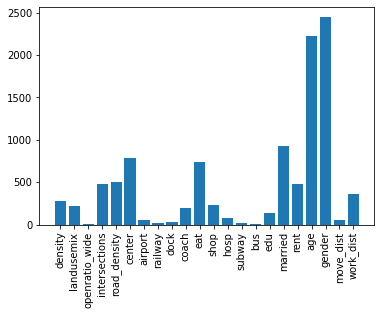

In [9]:
# 划分数据集
features_list = be_varies_name+['age','gender','move_dist','work_dist']
X = data[features_list]
y = data['walk_dist']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=1)

# 特征选择
X_train_fs, X_test_fs, fs = select_features(X_train, y_train, X_test)
# 打印特征得分
for i in range(len(fs.scores_)):
    print('Feature %s: %f' % (features_list[i], fs.scores_[i]))

plt.bar([i for i in range(len(fs.scores_))], fs.scores_)
plt.xticks([i for i in range(len(fs.scores_))], features_list, rotation='vertical')
plt.show()
# 根据得分选择变量：density, landusemix, intersections, road_density, center, eat, shop, age, gender, married, rent, work_dist

Feature density: 7911.434541
Feature landusemix: 0.303407
Feature openratio_wide: 398.493472
Feature intersections: 3636.608604
Feature road_density: 8547.389153
Feature center: 6207.713138
Feature airport: 3129.740442
Feature railway: 10822.519406
Feature dock: 19720.066756
Feature coach: 789.286752
Feature eat: 1965.353614
Feature shop: 4009.124433
Feature hosp: 10546.833642
Feature subway: 3634.479247
Feature bus: 1399.357651
Feature edu: 19070.530991
Feature married: 3069.012981
Feature rent: 10642.605064
Feature age: 3069.008250
Feature gender: 2589.761886
Feature move_dist: 12.520896
Feature work_dist: 208879.074118


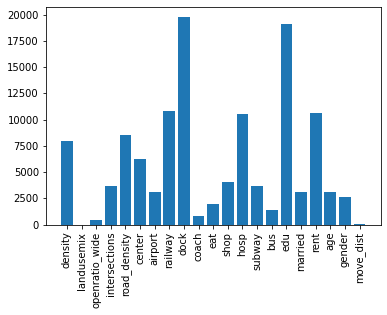

In [17]:
y = data['chain_complexity']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=1)

# 特征选择
X_train_fs, X_test_fs, fs = select_features(X_train, y_train, X_test)
# 打印特征得分
for i in range(len(fs.scores_)):
    print('Feature %s: %f' % (features_list[i], fs.scores_[i]))

plt.bar([i for i in range(len(fs.scores_)-1)], fs.scores_[0:-1])
plt.xticks([i for i in range(len(fs.scores_)-1)], features_list[0:-1], rotation='vertical')
plt.show()
# 根据得分选择变量：density, intersections, road_density, center, subway, edu, rent, age, gender, work_dist

Feature density: 105551.452450
Feature landusemix: 1664.345593
Feature openratio_wide: 29339.974403
Feature intersections: 27769.044661
Feature road_density: 29589.281565
Feature center: 8606.022435
Feature airport: 24469.631631
Feature railway: 16884.595157
Feature dock: 60220.818248
Feature coach: 8876.133518
Feature eat: 119797.905384
Feature shop: 93490.374967
Feature hosp: 108755.047727
Feature subway: 70159.507401
Feature bus: 28409.654290
Feature edu: 43335.828448
Feature married: 28.121732
Feature rent: 4780.404963
Feature age: 34901.778027
Feature gender: 7076.486931
Feature move_dist: 10571.813206
Feature work_dist: 212803.234752


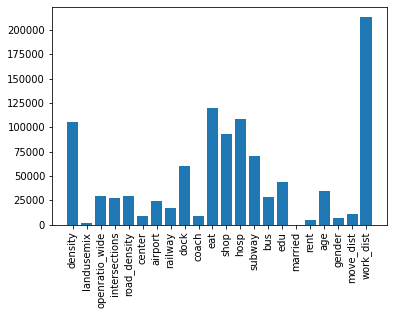

In [13]:
y = data['metro_dist_ratio']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=1)

# 特征选择
X_train_fs, X_test_fs, fs = select_features(X_train, y_train, X_test)
# 打印特征得分
for i in range(len(fs.scores_)):
    print('Feature %s: %f' % (features_list[i], fs.scores_[i]))

plt.bar([i for i in range(len(fs.scores_))], fs.scores_)
plt.xticks([i for i in range(len(fs.scores_))], features_list, rotation='vertical')
plt.show()

# 水平值-水平值回归模型

In [2]:
regress_data = pd.read_csv("D:/317研究组/4 居住自选择/data/final_data/all_data/all_data.csv")
regress_data = regress_data[['who','T','move','P','holiday', 'storm', 'density', 'landusemix', 'road_density', 'intersections', 'center', 'work_dist', 'subway', 'bus', 'age', 'gender', 'walk_dist', 'chain_complexity', 'metro_dist_ratio']]

In [3]:
# 中心化
features_list = ['density', 'landusemix', 'road_density', 'intersections', 'center', 'subway', 'bus', 'work_dist']
for col in features_list:
    regress_data[col] = regress_data[col] - regress_data[col].mean()
regress_data.head()

,who,T,move,P,holiday,storm,density,landusemix,road_density,intersections,center,work_dist,subway,bus,age,gender,walk_dist,chain_complexity,metro_dist_ratio
0,6717,1,0,0,1,0,12.669152,0.038009,1.582952,10.056654,-0.253236,0.957067,-0.12214,-0.314306,8.0,0.0,0.0,2.0,0.0
1,6717,2,0,0,0,0,12.669152,0.038009,1.582952,10.056654,-0.253236,0.957067,-0.12214,-0.314306,8.0,0.0,0.0,4.0,0.0
2,6717,3,0,0,0,0,12.669152,0.038009,1.582952,10.056654,-0.253236,0.957067,-0.12214,-0.314306,8.0,0.0,0.0,6.0,0.0
3,6717,4,0,0,0,0,12.669152,0.038009,1.582952,10.056654,-0.253236,0.957067,-0.12214,-0.314306,8.0,0.0,2263.0,2.0,0.0
4,6717,5,0,0,1,0,12.669152,0.038009,1.582952,10.056654,-0.253236,0.957067,-0.12214,-0.314306,8.0,0.0,0.0,2.0,0.0


In [4]:
formulas_dist1 = 'walk_dist ~ T + move + P + holiday + storm + density + landusemix + road_density + center + subway + bus + age + gender + work_dist + move:density + move:landusemix + move:road_density + move:center + move:work_dist + move:subway + move:bus + move:age + move:gender + P:density + P:landusemix + P:road_density + P:center + P:work_dist + P:subway + P:bus + P:age + P:gender'
model_dist1 = smf.mixedlm(formulas_dist1, regress_data, groups=regress_data['who'])
model_dist1 = model_dist1.fit()
print(model_dist1.summary())

              Mixed Linear Model Regression Results
Model:              MixedLM   Dependent Variable:   walk_dist     
No. Observations:   7780960   Method:               REML          
No. Groups:         21289     Scale:                314494.2940   
Min. group size:    365       Log-Likelihood:       -60322868.8822
Max. group size:    605       Converged:            Yes           
Mean group size:    365.5                                         
------------------------------------------------------------------
                    Coef.   Std.Err.    z    P>|z|  [0.025  0.975]
------------------------------------------------------------------
Intercept            72.129    4.080  17.679 0.000  64.132  80.125
T                     0.054    0.005  10.101 0.000   0.044   0.064
move                  9.703    2.591   3.746 0.000   4.626  14.780
P                    -0.037    0.022  -1.707 0.088  -0.079   0.005
holiday              -9.657    0.433 -22.284 0.000 -10.507  -8.808
storm     

In [5]:
del model_dist1
gc.collect()

1402

In [7]:
formulas_chain1 = 'chain_complexity ~ T + move + P + holiday + storm + density + landusemix + road_density + center + subway + bus + age + gender + work_dist + move:density + move:landusemix + move:road_density + move:center + move:work_dist + move:subway + move:bus + move:age + move:gender + P:density + P:landusemix + P:road_density + P:center + P:work_dist + P:subway + P:bus + P:age + P:gender'
model_chain1 = smf.mixedlm(formulas_chain1, regress_data, groups=regress_data['who'])
model_chain1 = model_chain1.fit()
print(model_chain1.summary())

            Mixed Linear Model Regression Results
Model:            MixedLM Dependent Variable: chain_complexity
No. Observations: 7780960 Method:             REML            
No. Groups:       21289   Scale:              1.8778          
Min. group size:  365     Log-Likelihood:     -13543568.9960  
Max. group size:  605     Converged:          Yes             
Mean group size:  365.5                                       
--------------------------------------------------------------
                  Coef.  Std.Err.    z     P>|z| [0.025 0.975]
--------------------------------------------------------------
Intercept          1.216    0.022   54.584 0.000  1.172  1.260
T                  0.002    0.000  169.094 0.000  0.002  0.002
move               0.013    0.006    2.082 0.037  0.001  0.026
P                 -0.003    0.000  -52.543 0.000 -0.003 -0.003
holiday           -0.332    0.001 -313.055 0.000 -0.334 -0.329
storm             -0.008    0.001   -5.054 0.000 -0.011 -0.005
densi

In [8]:
del model_chain1
gc.collect()

24539

In [9]:
formulas_ratio1 = 'metro_dist_ratio ~ T + move + P + holiday + storm + density + landusemix + road_density + center + subway + bus + age + gender + work_dist + move:density + move:landusemix + move:road_density + move:center + move:work_dist + move:subway + move:bus + move:age + move:gender + P:density + P:landusemix + P:road_density + P:center + P:work_dist + P:subway + P:bus + P:age + P:gender'
model_ratio1 = smf.mixedlm(formulas_ratio1, regress_data, groups=regress_data['who'])
model_ratio1 = model_ratio1.fit()
print(model_ratio1.summary())

            Mixed Linear Model Regression Results
Model:            MixedLM Dependent Variable: metro_dist_ratio
No. Observations: 7780960 Method:             REML            
No. Groups:       21289   Scale:              0.0662          
Min. group size:  365     Log-Likelihood:     -529170.8002    
Max. group size:  605     Converged:          Yes             
Mean group size:  365.5                                       
--------------------------------------------------------------
                  Coef.  Std.Err.    z     P>|z| [0.025 0.975]
--------------------------------------------------------------
Intercept          0.172    0.004   43.405 0.000  0.164  0.180
T                  0.000    0.000   59.445 0.000  0.000  0.000
move               0.041    0.001   34.210 0.000  0.038  0.043
P                  0.000    0.000    9.551 0.000  0.000  0.000
holiday           -0.055    0.000 -275.022 0.000 -0.055 -0.054
storm             -0.001    0.000   -4.949 0.000 -0.002 -0.001
densi

# 归一化回归模型

In [6]:
regress_data = pd.read_csv("D:/317研究组/4 居住自选择/data/final_data/all_data/all_data.csv")
regress_data = regress_data[['who','T','move','P','holiday', 'storm', 'density', 'landusemix', 'road_density', 'intersections', 'center', 'work_dist', 'subway', 'bus', 'age', 'gender', 'walk_dist', 'chain_complexity', 'metro_dist_ratio','move_time']]

In [7]:
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()
regress_data[['density', 'landusemix', 'road_density', 'intersections', 'center', 'subway', 'bus', 'work_dist']] = scaler.fit_transform(regress_data[['density', 'landusemix', 'road_density', 'intersections', 'center', 'subway', 'bus', 'work_dist']])

In [8]:
regress_data

,who,T,move,P,holiday,storm,density,landusemix,road_density,intersections,center,work_dist,subway,bus,age,gender,walk_dist,chain_complexity,metro_dist_ratio,move_time
0,6717,1,0,0,1,0,0.330448,0.768967,0.344449,0.221250,0.169338,0.135019,0.066667,0.198113,8.0,0.0,0.0,2.000000,0.000000,151
1,6717,2,0,0,0,0,0.330448,0.768967,0.344449,0.221250,0.169338,0.135019,0.066667,0.198113,8.0,0.0,0.0,4.000000,0.000000,151
2,6717,3,0,0,0,0,0.330448,0.768967,0.344449,0.221250,0.169338,0.135019,0.066667,0.198113,8.0,0.0,0.0,6.000000,0.000000,151
3,6717,4,0,0,0,0,0.330448,0.768967,0.344449,0.221250,0.169338,0.135019,0.066667,0.198113,8.0,0.0,2263.0,2.000000,0.000000,151
4,6717,5,0,0,1,0,0.330448,0.768967,0.344449,0.221250,0.169338,0.135019,0.066667,0.198113,8.0,0.0,0.0,2.000000,0.000000,151
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7780955,78965228,361,1,211,0,0,0.118624,0.673407,0.657389,0.395089,0.241859,0.000991,0.000000,0.215633,6.0,1.0,0.0,2.333333,0.000000,151
7780956,78965228,362,1,212,1,0,0.118624,0.673407,0.657389,0.395089,0.241859,0.000991,0.000000,0.215633,6.0,1.0,2915.0,3.000000,0.168721,151
7780957,78965228,363,1,213,1,0,0.118624,0.673407,0.657389,0.395089,0.241859,0.000991,0.000000,0.215633,6.0,1.0,2828.0,2.500000,0.180461,151
7780958,78965228,364,1,214,0,0,0.118624,0.673407,0.657389,0.395089,0.241859,0.000991,0.000000,0.215633,6.0,1.0,500.0,2.000000,0.000000,151


In [5]:
formulas_dist2 = 'walk_dist ~ T + move + P + holiday + storm + density + landusemix + road_density + center + subway + bus + age + gender + work_dist + move:density + move:landusemix + move:road_density + move:center + move:work_dist + move:subway + move:bus + move:age + move:gender + P:density + P:landusemix + P:road_density + P:center + P:work_dist + P:subway + P:bus + P:age + P:gender'
model_dist2 = smf.mixedlm(formulas_dist2, regress_data, groups=regress_data['who'])
model_dist2 = model_dist2.fit()
print(model_dist2.summary())

               Mixed Linear Model Regression Results
Model:                MixedLM   Dependent Variable:   walk_dist     
No. Observations:     7780960   Method:               REML          
No. Groups:           21289     Scale:                314494.2940   
Min. group size:      365       Log-Likelihood:       -60322801.7366
Max. group size:      605       Converged:            Yes           
Mean group size:      365.5                                         
--------------------------------------------------------------------
                    Coef.   Std.Err.    z    P>|z|  [0.025   0.975] 
--------------------------------------------------------------------
Intercept            82.536    5.325  15.501 0.000   72.100   92.972
T                     0.054    0.005  10.101 0.000    0.044    0.064
move                 -0.191    6.635  -0.029 0.977  -13.196   12.814
P                    -0.057    0.047  -1.219 0.223   -0.150    0.035
holiday              -9.657    0.433 -22.284 0.000

In [13]:
# 预测
predict_data = regress_data[(regress_data['T']==regress_data['move_time']-1) | (regress_data['T']==regress_data['move_time']) | (regress_data['T']==365)]
# 控制变量取0值或平均值
predict_data['holiday'] = 0
predict_data['storm'] = 0
predict_data['gender'] = 0
predict_data['age'] = predict_data['age'].mean()

C:\Users\huangnx\AppData\Local\Temp\ipykernel_76344\3699891160.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  predict_data['holiday'] = 0
C:\Users\huangnx\AppData\Local\Temp\ipykernel_76344\3699891160.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  predict_data['storm'] = 0
C:\Users\huangnx\AppData\Local\Temp\ipykernel_76344\3699891160.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the ca

In [14]:
predicted_y = model_dist2.predict(predict_data)
predict_data['walk_dist_pred'] = predicted_y

C:\Users\huangnx\AppData\Local\Temp\ipykernel_76344\1245642215.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  predict_data['walk_dist_pred'] = predicted_y


In [15]:
predict_data

,who,T,move,P,holiday,storm,density,landusemix,road_density,intersections,...,work_dist,subway,bus,age,gender,walk_dist,chain_complexity,metro_dist_ratio,move_time,walk_dist_pred
149,6717,150,0,0,0,0,0.330448,0.768967,0.344449,0.221250,...,0.449854,0.066667,0.198113,6.607608,0,0.0,4.0,0.000000,151,89.367977
150,6717,151,1,1,0,0,0.270537,0.624397,0.351494,0.089732,...,0.449854,0.000000,0.074124,6.607608,0,0.0,3.0,0.000000,151,90.504897
364,6717,365,1,215,0,0,0.270537,0.624397,0.351494,0.089732,...,0.162510,0.000000,0.074124,6.607608,0,0.0,2.0,0.000000,151,149.668053
557,9226,193,0,0,0,0,0.570216,0.731605,0.247463,0.175000,...,0.289967,0.222222,0.243711,6.607608,0,0.0,8.0,0.000000,194,105.206622
558,9226,194,1,1,0,0,0.060704,0.778914,0.284694,0.196875,...,0.289967,0.296296,0.136268,6.607608,0,500.0,8.0,0.000000,194,113.880347
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7780593,78964879,365,1,209,0,0,0.052609,0.588584,0.073952,0.000000,...,0.082983,0.133333,0.028302,6.607608,0,0.0,0.0,0.000000,157,153.127753
7780594,78964879,365,1,209,0,0,0.052609,0.588584,0.073952,0.000000,...,0.082983,0.133333,0.028302,6.607608,0,0.0,0.0,0.000000,157,153.127753
7780744,78965228,150,0,0,0,0,0.480257,0.814087,0.344137,0.191250,...,0.094935,0.266667,0.433962,6.607608,0,0.0,3.0,0.817753,151,137.815384
7780745,78965228,151,1,1,0,0,0.118624,0.673407,0.657389,0.395089,...,0.094935,0.000000,0.215633,6.607608,0,1118.0,4.0,0.000000,151,122.513478


In [16]:
del model_dist2
gc.collect()

0

In [17]:
formulas_chain2 = 'chain_complexity ~ T + move + P + holiday + storm + density + landusemix + road_density + center + subway + bus + age + gender + work_dist + move:density + move:landusemix + move:road_density + move:center + move:work_dist + move:subway + move:bus + move:age + move:gender + P:density + P:landusemix + P:road_density + P:center + P:work_dist + P:subway + P:bus + P:age + P:gender'
model_chain2 = smf.mixedlm(formulas_chain2, regress_data, groups=regress_data['who'])
model_chain2 = model_chain2.fit()
print(model_chain2.summary())

            Mixed Linear Model Regression Results
Model:            MixedLM Dependent Variable: chain_complexity
No. Observations: 7780960 Method:             REML            
No. Groups:       21289   Scale:              1.8778          
Min. group size:  365     Log-Likelihood:     -13543501.8504  
Max. group size:  605     Converged:          Yes             
Mean group size:  365.5                                       
--------------------------------------------------------------
                  Coef.  Std.Err.    z     P>|z| [0.025 0.975]
--------------------------------------------------------------
Intercept          1.311    0.024   54.968 0.000  1.264  1.357
T                  0.002    0.000  169.094 0.000  0.002  0.002
move               0.024    0.016    1.491 0.136 -0.008  0.056
P                 -0.002    0.000  -20.795 0.000 -0.003 -0.002
holiday           -0.332    0.001 -313.055 0.000 -0.334 -0.329
storm             -0.008    0.001   -5.054 0.000 -0.011 -0.005
densi

In [18]:
predicted_y = model_chain2.predict(predict_data)
predict_data['chain_complexity_pred'] = predicted_y

C:\Users\huangnx\AppData\Local\Temp\ipykernel_76344\1500896092.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  predict_data['chain_complexity_pred'] = predicted_y


In [19]:
del model_chain2
gc.collect()

644

In [9]:
formulas_ratio2 = 'metro_dist_ratio ~ T + move + P + holiday + storm + density + landusemix + road_density + center + subway + bus + age + gender + work_dist + move:density + move:landusemix + move:road_density + move:center + move:work_dist + move:subway + move:bus + move:age + move:gender + P:density + P:landusemix + P:road_density + P:center + P:work_dist + P:subway + P:bus + P:age + P:gender'
model_ratio2 = smf.mixedlm(formulas_ratio2, regress_data, groups=regress_data['who'])
model_ratio2 = model_ratio2.fit()
print(model_ratio2.summary())

            Mixed Linear Model Regression Results
Model:            MixedLM Dependent Variable: metro_dist_ratio
No. Observations: 7780960 Method:             REML            
No. Groups:       21289   Scale:              0.0662          
Min. group size:  365     Log-Likelihood:     -529103.6546    
Max. group size:  605     Converged:          Yes             
Mean group size:  365.5                                       
--------------------------------------------------------------
                  Coef.  Std.Err.    z     P>|z| [0.025 0.975]
--------------------------------------------------------------
Intercept          0.152    0.004   35.576 0.000  0.144  0.160
T                  0.000    0.000   59.445 0.000  0.000  0.000
move               0.005    0.003    1.758 0.079 -0.001  0.011
P                 -0.000    0.000   -1.362 0.173 -0.000  0.000
holiday           -0.055    0.000 -275.022 0.000 -0.055 -0.054
storm             -0.001    0.000   -4.949 0.000 -0.002 -0.001
densi

In [20]:
# 地铁转为百分比再建模
regress_data['subway100'] = regress_data['metro_dist_ratio'] * 100

In [21]:
formulas_ratio3 = 'subway100 ~ T + move + P + holiday + storm + density + landusemix + road_density + center + subway + bus + age + gender + work_dist + move:density + move:landusemix + move:road_density + move:center + move:work_dist + move:subway + move:bus + move:age + move:gender + P:density + P:landusemix + P:road_density + P:center + P:work_dist + P:subway + P:bus + P:age + P:gender'
model_ratio3 = smf.mixedlm(formulas_ratio3, regress_data, groups=regress_data['who'])
model_ratio3 = model_ratio3.fit()
print(model_ratio3.summary())

             Mixed Linear Model Regression Results
Model:             MixedLM  Dependent Variable:  subway100     
No. Observations:  7780960  Method:              REML          
No. Groups:        21289    Scale:               662.1773      
Min. group size:   365      Log-Likelihood:      -36361596.6944
Max. group size:   605      Converged:           Yes           
Mean group size:   365.5                                       
---------------------------------------------------------------
                   Coef.  Std.Err.    z     P>|z| [0.025 0.975]
---------------------------------------------------------------
Intercept          15.203    0.427   35.576 0.000 14.365 16.041
T                   0.015    0.000   59.445 0.000  0.014  0.015
move                0.539    0.307    1.758 0.079 -0.062  1.141
P                  -0.003    0.002   -1.362 0.173 -0.007  0.001
holiday            -5.469    0.020 -275.022 0.000 -5.508 -5.430
storm              -0.139    0.028   -4.949 0.000 -0.

In [22]:
predicted_y = model_ratio3.predict(predict_data)
predict_data['subway100_pred'] = predicted_y

C:\Users\huangnx\AppData\Local\Temp\ipykernel_76344\421498576.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  predict_data['subway100_pred'] = predicted_y


In [16]:
del model_ratio3
gc.collect()

24264

In [23]:
predict_data.to_csv("D:/317研究组/4 居住自选择/data/final_data/all_data/predict_data.csv",index=False)

# 变化量回归模型

In [12]:
regress_data = data[['who','T','move','P','move_time','holiday','temperature', 'percipit', 'density', 'landusemix', 'openratio_wide', 'road_density', 'intersections', 'center', 'work_dist', 'subway', 'bus', 'age', 'gender', 'walk_dist', 'chain_complexity', 'metro_dist_ratio', 'density_change', 'landusemix_change', 'openratio_wide_change', 'road_density_change', 'intersections_change', 'center_change', 'subway_change', 'bus_change']]

# 中心化
features_list = ['walk_dist', 'density', 'landusemix', 'openratio_wide', 'road_density', 'intersections', 'center', 'subway', 'bus', 'work_dist']
for col in features_list:
    regress_data[col] = regress_data[col] - regress_data[col].mean()
regress_data.head()

C:\Users\317gy\AppData\Local\Temp\ipykernel_48636\4018160518.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  regress_data[col] = regress_data[col] - regress_data[col].mean()


,who,T,move,P,move_time,holiday,temperature,percipit,density,landusemix,...,chain_complexity,metro_dist_ratio,density_change,landusemix_change,openratio_wide_change,road_density_change,intersections_change,center_change,subway_change,bus_change
0,6717,1,0,0,151,1,11.3,0.0,11.414675,0.038839,...,2.0,0.0,-8.91934,-0.114394,0.129132,0.625422,-24.939683,2.283825,-0.355556,-4.673016
1,6717,2,0,0,151,0,12.4,0.1,11.414675,0.038839,...,4.0,0.0,-8.91934,-0.114394,0.129132,0.625422,-24.939683,2.283825,-0.355556,-4.673016
2,6717,3,0,0,151,0,13.2,0.0,11.414675,0.038839,...,6.0,0.0,-8.91934,-0.114394,0.129132,0.625422,-24.939683,2.283825,-0.355556,-4.673016
3,6717,4,0,0,151,0,17.2,0.1,11.414675,0.038839,...,2.0,0.0,-8.91934,-0.114394,0.129132,0.625422,-24.939683,2.283825,-0.355556,-4.673016
4,6717,5,0,0,151,1,18.6,0.0,11.414675,0.038839,...,2.0,0.0,-8.91934,-0.114394,0.129132,0.625422,-24.939683,2.283825,-0.355556,-4.673016


In [13]:
formulas = 'walk_dist ~ T + move + P + holiday + temperature + percipit + density + landusemix + openratio_wide + intersections + road_density + center + subway + bus + age + gender + work_dist + move:density_change + move:landusemix_change + move:openratio_wide_change + move:intersections_change + move:road_density_change + move:center_change + move:subway_change + move:bus_change + move:age + move:gender + P:density_change + P:landusemix_change + P:openratio_wide_change + P:intersections_change + P:road_density_change + P:center_change + P:subway_change + P:bus_change + P:age + P:gender'
model = smf.mixedlm(formulas, regress_data, groups=regress_data['who'])
model = model.fit()
print(model.summary())

                   Mixed Linear Model Regression Results
Model:                 MixedLM      Dependent Variable:      walk_dist     
No. Observations:      7770485      Method:                  REML          
No. Groups:            21289        Scale:                   314507.1315   
Min. group size:       365          Log-Likelihood:          -60241908.3188
Max. group size:       365          Converged:               Yes           
Mean group size:       365.0                                               
---------------------------------------------------------------------------
                             Coef.   Std.Err.    z    P>|z|  [0.025  0.975]
---------------------------------------------------------------------------
Intercept                     -5.439    4.085  -1.331 0.183 -13.445   2.568
T                              0.204    0.007  29.038 0.000   0.190   0.218
move                          13.160    2.453   5.364 0.000   8.352  17.969
P                             -

### 使用标准化变量查看标准变化

In [14]:
regress_data = data[['who','T','move','P','holiday','temperature', 'percipit', 'density', 'landusemix', 'openratio_wide', 'road_density', 'intersections', 'center', 'work_dist', 'subway', 'bus', 'age', 'gender', 'walk_dist', 'chain_complexity', 'metro_dist_ratio', 'density_change', 'landusemix_change', 'openratio_wide_change', 'road_density_change', 'intersections_change', 'center_change', 'subway_change', 'bus_change']]

# 标准化
features_list = ['walk_dist', 'density', 'landusemix', 'openratio_wide', 'road_density', 'intersections', 'center', 'subway', 'bus', 'work_dist', 'density_change', 'landusemix_change', 'openratio_wide_change', 'road_density_change', 'intersections_change', 'center_change', 'subway_change', 'bus_change', 'temperature', 'percipit']
scaler = StandardScaler()
std_regress_data = regress_data[features_list]
std_regress_data = scaler.fit_transform(std_regress_data)
# 更新regress data
regress_data[features_list] = std_regress_data
regress_data.head()

C:\Users\317gy\AppData\Local\Temp\ipykernel_48636\1978653536.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  regress_data[features_list] = std_regress_data


,who,T,move,P,holiday,temperature,percipit,density,landusemix,openratio_wide,...,chain_complexity,metro_dist_ratio,density_change,landusemix_change,openratio_wide_change,road_density_change,intersections_change,center_change,subway_change,bus_change
0,6717,1,0,0,1,-2.820366,-0.385465,0.470986,0.495686,-0.816624,...,2.0,0.0,-0.202362,-1.079849,0.85783,0.101747,-0.736847,0.446555,-0.307883,-0.809489
1,6717,2,0,0,0,-2.576687,-0.378001,0.470986,0.495686,-0.816624,...,4.0,0.0,-0.202362,-1.079849,0.85783,0.101747,-0.736847,0.446555,-0.307883,-0.809489
2,6717,3,0,0,0,-2.399466,-0.385465,0.470986,0.495686,-0.816624,...,6.0,0.0,-0.202362,-1.079849,0.85783,0.101747,-0.736847,0.446555,-0.307883,-0.809489
3,6717,4,0,0,0,-1.513360,-0.378001,0.470986,0.495686,-0.816624,...,2.0,0.0,-0.202362,-1.079849,0.85783,0.101747,-0.736847,0.446555,-0.307883,-0.809489
4,6717,5,0,0,1,-1.203223,-0.385465,0.470986,0.495686,-0.816624,...,2.0,0.0,-0.202362,-1.079849,0.85783,0.101747,-0.736847,0.446555,-0.307883,-0.809489


In [18]:
formulas = 'walk_dist ~ T + move + P + holiday + temperature + percipit + density + landusemix + openratio_wide + road_density + center + subway + bus + age + gender + work_dist + move:density_change + move:landusemix_change + move:openratio_wide_change + move:road_density_change + move:center_change + move:subway_change + move:bus_change + move:age + move:gender + P:density_change + P:landusemix_change + P:openratio_wide_change + P:road_density_change + P:center_change + P:subway_change + P:bus_change + P:age + P:gender'
model = smf.mixedlm(formulas, regress_data, groups=regress_data['who'])
model = model.fit()
print(model.summary())

                Mixed Linear Model Regression Results
Model:                MixedLM    Dependent Variable:    walk_dist     
No. Observations:     7780960    Method:                REML          
No. Groups:           21289      Scale:                 0.9396        
Min. group size:      365        Log-Likelihood:        -10831961.1945
Max. group size:      605        Converged:             Yes           
Mean group size:      365.5                                           
----------------------------------------------------------------------
                           Coef.  Std.Err.    z    P>|z| [0.025 0.975]
----------------------------------------------------------------------
Intercept                  -0.114    0.007 -16.894 0.000 -0.127 -0.101
T                           0.000    0.000  29.823 0.000  0.000  0.000
move                        0.022    0.004   5.275 0.000  0.014  0.031
P                          -0.001    0.000 -14.729 0.000 -0.001 -0.000
holiday                

# 敏感性分析

## 删除搬家前后两周数据

In [16]:
regress_data = data[['who','T','move','P','move_time','holiday','temperature', 'percipit', 'density', 'landusemix', 'openratio_wide', 'road_density', 'intersections', 'center', 'work_dist', 'subway', 'bus', 'age', 'gender', 'walk_dist', 'chain_complexity', 'metro_dist_ratio', 'density_change', 'landusemix_change', 'openratio_wide_change', 'road_density_change', 'intersections_change', 'center_change', 'subway_change', 'bus_change']]

# 删除搬家前后两周数据
regress_data = regress_data[(regress_data['T']>regress_data['move_time']+14) | (regress_data['T']<=regress_data['move_time']-14)]
regress_data.reset_index(drop=True, inplace=True)

# 重构T
n_days = 365 - 28
sample = len(regress_data['who'].unique())
T = np.tile(np.arange(1,n_days+1),sample)
regress_data['T'] = T

# 重构P
regress_data['P'] = regress_data['P'] - 14
regress_data['P'] = regress_data['P'].apply(lambda x: np.clip(x, 0, None))

# 中心化
features_list = ['walk_dist', 'density', 'landusemix', 'openratio_wide', 'road_density', 'intersections', 'center', 'subway', 'bus', 'work_dist']
for col in features_list:
    regress_data[col] = regress_data[col] - regress_data[col].mean()
regress_data.head()

,who,T,move,P,move_time,holiday,temperature,percipit,density,landusemix,...,chain_complexity,metro_dist_ratio,density_change,landusemix_change,openratio_wide_change,road_density_change,intersections_change,center_change,subway_change,bus_change
0,6717,1,0,0,151,1,11.3,0.0,11.414675,0.038839,...,2.0,0.0,-8.91934,-0.114394,0.129132,0.625422,-24.939683,2.283825,-0.355556,-4.673016
1,6717,2,0,0,151,0,12.4,0.1,11.414675,0.038839,...,4.0,0.0,-8.91934,-0.114394,0.129132,0.625422,-24.939683,2.283825,-0.355556,-4.673016
2,6717,3,0,0,151,0,13.2,0.0,11.414675,0.038839,...,6.0,0.0,-8.91934,-0.114394,0.129132,0.625422,-24.939683,2.283825,-0.355556,-4.673016
3,6717,4,0,0,151,0,17.2,0.1,11.414675,0.038839,...,2.0,0.0,-8.91934,-0.114394,0.129132,0.625422,-24.939683,2.283825,-0.355556,-4.673016
4,6717,5,0,0,151,1,18.6,0.0,11.414675,0.038839,...,2.0,0.0,-8.91934,-0.114394,0.129132,0.625422,-24.939683,2.283825,-0.355556,-4.673016


In [17]:
formulas = 'walk_dist ~ T + move + P + holiday + temperature + percipit + density + landusemix + openratio_wide + road_density + intersections + center + subway + bus + age + gender + work_dist + move:density_change + move:landusemix_change + move:openratio_wide_change + move:road_density_change + move:intersections_change + move:center_change + move:subway_change + move:bus_change + move:age + move:gender + P:density_change + P:landusemix_change + P:openratio_wide_change + P:road_density_change + P:intersections_change + P:center_change + P:subway_change + P:bus_change + P:age + P:gender'
model = smf.mixedlm(formulas, regress_data, groups=regress_data['who'])
model = model.fit()
print(model.summary())

                   Mixed Linear Model Regression Results
Model:                 MixedLM      Dependent Variable:      walk_dist     
No. Observations:      7174393      Method:                  REML          
No. Groups:            21289        Scale:                   313774.4002   
Min. group size:       337          Log-Likelihood:          -55614304.7427
Max. group size:       337          Converged:               Yes           
Mean group size:       337.0                                               
---------------------------------------------------------------------------
                             Coef.   Std.Err.    z    P>|z|  [0.025  0.975]
---------------------------------------------------------------------------
Intercept                     -8.798    4.153  -2.118 0.034 -16.938  -0.658
T                              0.197    0.008  26.165 0.000   0.182   0.211
move                          14.949    2.566   5.825 0.000   9.919  19.979
P                             -

In [24]:
data_describe = data[['holiday','temperature', 'percipit', 'density', 'landusemix', 'openratio_wide', 'road_density', 'intersections', 'center', 'work_dist', 'subway', 'bus', 'age', 'gender', 'walk_dist', 'density_change', 'landusemix_change', 'openratio_wide_change', 'road_density_change', 'intersections_change', 'center_change', 'subway_change', 'bus_change']]
data_describe.describe().loc[['mean','std']]

,holiday,temperature,percipit,density,landusemix,openratio_wide,road_density,intersections,center,work_dist,...,gender,walk_dist,density_change,landusemix_change,openratio_wide_change,road_density_change,intersections_change,center_change,subway_change,bus_change
mean,0.315068,24.031507,5.164110,37.780748,0.667136,0.086082,29.394870,33.196460,6.455956,4.952836,...,0.344591,119.771315,-2.529932,0.002334,0.003842,-0.736464,-2.485687,-0.084263,-0.059720,-0.275860
std,0.464543,4.514133,13.397093,24.235699,0.078354,0.105413,9.917015,24.140888,3.849886,4.891947,...,0.475235,578.473591,31.574220,0.108096,0.146056,13.384988,30.473071,5.303011,0.960867,5.432014


In [39]:
# 随机选取5%的who
who_list = regress_data['who'].unique().tolist()
who_list = np.random.choice(who_list, int(len(who_list)*0.45), replace=False)

# 选取这些who的数据，建模
regress_data_45 = regress_data[regress_data['who'].isin(who_list)]

## 二次方时间趋势

In [23]:
regress_data = data[['who','T','move','P','move_time','holiday','temperature', 'percipit', 'density', 'landusemix', 'openratio_wide', 'road_density', 'intersections', 'center', 'work_dist', 'subway', 'bus', 'age', 'gender', 'walk_dist', 'chain_complexity', 'metro_dist_ratio', 'density_change', 'landusemix_change', 'openratio_wide_change', 'road_density_change', 'intersections_change', 'center_change', 'subway_change', 'bus_change']]
# 增加时间趋势的二次方项
regress_data['P2'] = regress_data['P']**2
# 中心化
# features_list = ['walk_dist', 'density', 'landusemix', 'openratio_wide', 'road_density', 'intersections', 'center', 'subway', 'bus', 'work_dist']
# for col in features_list:
#     regress_data[col] = regress_data[col] - regress_data[col].mean()
# regress_data.head()

C:\Users\317gy\AppData\Local\Temp\ipykernel_48636\448320405.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  regress_data['P2'] = regress_data['P']**2


In [24]:
# formulas = 'walk_dist ~ T + move + P + P2 + holiday + temperature + percipit + density + landusemix + openratio_wide + road_density + intersections + center + subway + bus + age + gender + work_dist + move:density_change + move:landusemix_change + move:openratio_wide_change + move:road_density_change + move:intersections_change + move:center_change + move:subway_change + move:bus_change + move:age + move:gender + P:density_change + P:landusemix_change + P:openratio_wide_change + P:road_density_change + P:intersections_change + P:center_change + P:subway_change + P:bus_change + P:age + P:gender + + P2:density_change + P2:landusemix_change + P2:openratio_wide_change + P2:road_density_change + P2:intersections_change + P2:center_change + P2:subway_change + P2:bus_change + P2:age + P2:gender'
formulas = 'walk_dist ~ T + move + P + P2 + holiday + temperature + percipit'
model = smf.mixedlm(formulas, regress_data, groups=regress_data['who'])
model = model.fit()
print(model.summary())

           Mixed Linear Model Regression Results
Model:            MixedLM Dependent Variable: walk_dist     
No. Observations: 7770485 Method:             REML          
No. Groups:       21289   Scale:              314553.3331   
Min. group size:  365     Log-Likelihood:     -60242674.8186
Max. group size:  365     Converged:          Yes           
Mean group size:  365.0                                     
------------------------------------------------------------
              Coef.   Std.Err.    z    P>|z|  [0.025  0.975]
------------------------------------------------------------
Intercept     151.411    1.696  89.256 0.000 148.086 154.735
T               0.204    0.007  28.995 0.000   0.190   0.218
move            8.693    0.985   8.821 0.000   6.761  10.624
P              -0.334    0.020 -16.533 0.000  -0.374  -0.295
P2              0.001    0.000   6.628 0.000   0.000   0.001
holiday        -9.624    0.435 -22.142 0.000 -10.476  -8.772
temperature    -2.356    0.074 -31.7

In [21]:
model.params

Intercept                     -6.726702
T                              0.200997
move                           9.822285
P                             -0.212354
P2                            -0.000484
holiday                       -9.625851
temperature                   -2.317678
percipit                      -0.261177
density                       -0.134069
landusemix                    39.175952
openratio_wide                14.715655
road_density                   0.334113
intersections                  0.245626
center                        -1.793707
subway                        -3.650308
bus                           -0.460967
age                           18.204177
gender                       -18.829092
work_dist                     -0.305627
move:density_change           -0.051554
move:landusemix_change        18.567447
move:openratio_wide_change    22.466548
move:road_density_change       0.203789
move:intersections_change      0.146141
move:center_change            -1.012903


## 5%验证

In [27]:
model_dist2_5 = smf.mixedlm(formulas_dist2, regress_data_5, groups=regress_data_5['who'])
model_dist2_5 = model_dist2_5.fit()
print(model_dist2_5.summary())

               Mixed Linear Model Regression Results
Model:                MixedLM   Dependent Variable:   walk_dist    
No. Observations:     389026    Method:               REML         
No. Groups:           1064      Scale:                315971.4147  
Min. group size:      365       Log-Likelihood:       -3016816.4384
Max. group size:      545       Converged:            Yes          
Mean group size:      365.6                                        
-------------------------------------------------------------------
                    Coef.   Std.Err.   z    P>|z|  [0.025   0.975] 
-------------------------------------------------------------------
Intercept            79.654   24.070  3.309 0.001   32.477  126.830
T                     0.026    0.024  1.085 0.278   -0.021    0.073
move                -20.889   30.879 -0.676 0.499  -81.412   39.633
P                    -0.341    0.213 -1.600 0.110   -0.758    0.077
holiday             -11.323    1.943 -5.828 0.000  -15.131   -7

In [28]:
model_chain2_5 = smf.mixedlm(formulas_chain2, regress_data_5, groups=regress_data_5['who'])
model_chain2_5 = model_chain2_5.fit()
print(model_chain2_5.summary())

            Mixed Linear Model Regression Results
Model:            MixedLM Dependent Variable: chain_complexity
No. Observations: 389026  Method:             REML            
No. Groups:       1064    Scale:              1.8467          
Min. group size:  365     Log-Likelihood:     -674059.9094    
Max. group size:  545     Converged:          Yes             
Mean group size:  365.6                                       
--------------------------------------------------------------
                   Coef.  Std.Err.    z    P>|z| [0.025 0.975]
--------------------------------------------------------------
Intercept           1.456    0.110  13.227 0.000  1.241  1.672
T                   0.002    0.000  37.065 0.000  0.002  0.002
move                0.052    0.075   0.694 0.488 -0.095  0.200
P                  -0.002    0.001  -3.863 0.000 -0.003 -0.001
holiday            -0.355    0.005 -75.654 0.000 -0.365 -0.346
storm               0.001    0.007   0.082 0.935 -0.012  0.014
densi

In [19]:
model_ratio3_5 = smf.mixedlm(formulas_ratio3, regress_data_5, groups=regress_data_5['who'])
model_ratio3_5 = model_ratio3_5.fit()
print(model_ratio3_5.summary())

             Mixed Linear Model Regression Results
Model:              MixedLM  Dependent Variable:  subway100    
No. Observations:   389026   Method:              REML         
No. Groups:         1064     Scale:               670.4121     
Min. group size:    365      Log-Likelihood:      -1820395.5717
Max. group size:    489      Converged:           Yes          
Mean group size:    365.6                                      
---------------------------------------------------------------
                   Coef.  Std.Err.    z    P>|z|  [0.025 0.975]
---------------------------------------------------------------
Intercept          14.824    1.923   7.709 0.000  11.055 18.593
T                   0.012    0.001  10.880 0.000   0.010  0.014
move               -2.344    1.379  -1.700 0.089  -5.046  0.359
P                   0.041    0.010   4.238 0.000   0.022  0.060
holiday            -5.607    0.089 -62.652 0.000  -5.782 -5.431
storm              -0.055    0.127  -0.432 0.665  -0.

## 15%验证

In [31]:
model_dist2_15 = smf.mixedlm(formulas_dist2, regress_data_15, groups=regress_data_15['who'])
model_dist2_15 = model_dist2_15.fit()
print(model_dist2_15.summary())

               Mixed Linear Model Regression Results
Model:                MixedLM   Dependent Variable:   walk_dist    
No. Observations:     1167046   Method:               REML         
No. Groups:           3193      Scale:                300942.2705  
Min. group size:      365       Log-Likelihood:       -9021804.8124
Max. group size:      455       Converged:            Yes          
Mean group size:      365.5                                        
-------------------------------------------------------------------
                    Coef.   Std.Err.    z    P>|z|  [0.025   0.975]
-------------------------------------------------------------------
Intercept            50.256   13.084   3.841 0.000   24.611  75.901
T                     0.043    0.014   3.206 0.001    0.017   0.070
move                  0.341   16.544   0.021 0.984  -32.084  32.766
P                     0.036    0.119   0.303 0.762   -0.197   0.270
holiday              -9.486    1.095  -8.665 0.000  -11.631  -7

In [32]:
model_chain2_15 = smf.mixedlm(formulas_chain2, regress_data_15, groups=regress_data_15['who'])
model_chain2_15 = model_chain2_15.fit()
print(model_chain2_15.summary())

            Mixed Linear Model Regression Results
Model:            MixedLM Dependent Variable: chain_complexity
No. Observations: 1167046 Method:             REML            
No. Groups:       3193    Scale:              1.8706          
Min. group size:  365     Log-Likelihood:     -2029250.0816   
Max. group size:  455     Converged:          Yes             
Mean group size:  365.5                                       
--------------------------------------------------------------
                  Coef.  Std.Err.    z     P>|z| [0.025 0.975]
--------------------------------------------------------------
Intercept          1.180    0.061   19.455 0.000  1.061  1.298
T                  0.002    0.000   63.984 0.000  0.002  0.002
move               0.272    0.042    6.542 0.000  0.191  0.353
P                 -0.003    0.000  -11.137 0.000 -0.004 -0.003
holiday           -0.345    0.003 -126.519 0.000 -0.351 -0.340
storm             -0.005    0.004   -1.365 0.172 -0.013  0.002
densi

In [21]:
model_ratio3_15 = smf.mixedlm(formulas_ratio3, regress_data_15, groups=regress_data_15['who'])
model_ratio3_15 = model_ratio3_15.fit()
print(model_ratio3_15.summary())

             Mixed Linear Model Regression Results
Model:              MixedLM  Dependent Variable:  subway100    
No. Observations:   1167082  Method:              REML         
No. Groups:         3193     Scale:               671.6854     
Min. group size:    365      Log-Likelihood:      -5462290.7687
Max. group size:    605      Converged:           Yes          
Mean group size:    365.5                                      
---------------------------------------------------------------
                   Coef.  Std.Err.    z     P>|z| [0.025 0.975]
---------------------------------------------------------------
Intercept          15.549    1.075   14.465 0.000 13.442 17.655
T                   0.013    0.001   20.183 0.000  0.012  0.014
move                0.009    0.786    0.011 0.991 -1.532  1.550
P                   0.003    0.005    0.500 0.617 -0.008  0.013
holiday            -5.437    0.052 -105.130 0.000 -5.538 -5.335
storm               0.062    0.073    0.848 0.397 -0.

## 25%验证

In [34]:
model_dist2_25 = smf.mixedlm(formulas_dist2, regress_data_25, groups=regress_data_25['who'])
model_dist2_25 = model_dist2_25.fit()
print(model_dist2_25.summary())

               Mixed Linear Model Regression Results
Model:               MixedLM   Dependent Variable:   walk_dist     
No. Observations:    1945446   Method:               REML          
No. Groups:          5322      Scale:                316844.6908   
Min. group size:     365       Log-Likelihood:       -15089295.1081
Max. group size:     489       Converged:            Yes           
Mean group size:     365.5                                         
-------------------------------------------------------------------
                    Coef.   Std.Err.    z    P>|z|  [0.025   0.975]
-------------------------------------------------------------------
Intercept            66.541   10.376   6.413 0.000   46.205  86.877
T                     0.076    0.011   7.087 0.000    0.055   0.097
move                 49.979   13.178   3.793 0.000   24.151  75.808
P                    -0.160    0.094  -1.710 0.087   -0.344   0.023
holiday             -10.329    0.870 -11.873 0.000  -12.034  -8

In [35]:
model_chain2_25 = smf.mixedlm(formulas_chain2, regress_data_25, groups=regress_data_25['who'])
model_chain2_25 = model_chain2_25.fit()
print(model_chain2_25.summary())

            Mixed Linear Model Regression Results
Model:            MixedLM Dependent Variable: chain_complexity
No. Observations: 1945446 Method:             REML            
No. Groups:       5322    Scale:              1.8709          
Min. group size:  365     Log-Likelihood:     -3382639.5152   
Max. group size:  489     Converged:          Yes             
Mean group size:  365.5                                       
--------------------------------------------------------------
                  Coef.  Std.Err.    z     P>|z| [0.025 0.975]
--------------------------------------------------------------
Intercept          1.228    0.047   26.353 0.000  1.136  1.319
T                  0.002    0.000   86.689 0.000  0.002  0.002
move               0.124    0.032    3.848 0.000  0.061  0.188
P                 -0.002    0.000  -10.423 0.000 -0.003 -0.002
holiday           -0.337    0.002 -159.618 0.000 -0.342 -0.333
storm             -0.010    0.003   -3.420 0.001 -0.016 -0.004
densi

In [23]:
model_ratio3_25 = smf.mixedlm(formulas_ratio3, regress_data_25, groups=regress_data_25['who'])
model_ratio3_25 = model_ratio3_25.fit()
print(model_ratio3_25.summary())

             Mixed Linear Model Regression Results
Model:              MixedLM  Dependent Variable:  subway100    
No. Observations:   1944670  Method:              REML         
No. Groups:         5322     Scale:               654.4207     
Min. group size:    365      Log-Likelihood:      -9076306.6810
Max. group size:    515      Converged:           Yes          
Mean group size:    365.4                                      
---------------------------------------------------------------
                   Coef.  Std.Err.    z     P>|z| [0.025 0.975]
---------------------------------------------------------------
Intercept          15.043    0.845   17.803 0.000 13.387 16.699
T                   0.017    0.000   33.876 0.000  0.016  0.018
move                2.593    0.617    4.201 0.000  1.384  3.803
P                  -0.023    0.004   -5.332 0.000 -0.032 -0.015
holiday            -5.282    0.040 -133.560 0.000 -5.359 -5.204
storm              -0.149    0.056   -2.665 0.008 -0.

## 35%验证

In [37]:
model_dist2_35 = smf.mixedlm(formulas_dist2, regress_data_35, groups=regress_data_35['who'])
model_dist2_35 = model_dist2_35.fit()
print(model_dist2_35.summary())

               Mixed Linear Model Regression Results
Model:                MixedLM   Dependent Variable:   walk_dist     
No. Observations:     2723597   Method:               REML          
No. Groups:           7451      Scale:                313879.5991   
Min. group size:      365       Log-Likelihood:       -21112085.8178
Max. group size:      545       Converged:            Yes           
Mean group size:      365.5                                         
--------------------------------------------------------------------
                    Coef.   Std.Err.    z    P>|z|  [0.025   0.975] 
--------------------------------------------------------------------
Intercept            78.112    8.904   8.773 0.000   60.661   95.563
T                     0.053    0.009   5.829 0.000    0.035    0.070
move                  5.555   11.137   0.499 0.618  -16.273   27.383
P                     0.110    0.079   1.391 0.164   -0.045    0.264
holiday             -10.553    0.732 -14.420 0.000

In [38]:
model_chain2_35 = smf.mixedlm(formulas_chain2, regress_data_35, groups=regress_data_35['who'])
model_chain2_35 = model_chain2_35.fit()
print(model_chain2_35.summary())

            Mixed Linear Model Regression Results
Model:            MixedLM Dependent Variable: chain_complexity
No. Observations: 2723597 Method:             REML            
No. Groups:       7451    Scale:              1.8835          
Min. group size:  365     Log-Likelihood:     -4744963.3731   
Max. group size:  545     Converged:          Yes             
Mean group size:  365.5                                       
--------------------------------------------------------------
                  Coef.  Std.Err.    z     P>|z| [0.025 0.975]
--------------------------------------------------------------
Intercept          1.255    0.041   30.665 0.000  1.175  1.335
T                  0.002    0.000   97.825 0.000  0.002  0.002
move               0.107    0.028    3.886 0.000  0.053  0.161
P                 -0.003    0.000  -13.884 0.000 -0.003 -0.002
holiday           -0.331    0.002 -184.460 0.000 -0.334 -0.327
storm             -0.007    0.003   -2.638 0.008 -0.012 -0.002
densi

In [25]:
model_ratio3_35 = smf.mixedlm(formulas_ratio3, regress_data_35, groups=regress_data_35['who'])
model_ratio3_35 = model_ratio3_35.fit()
print(model_ratio3_35.summary())

             Mixed Linear Model Regression Results
Model:             MixedLM  Dependent Variable:  subway100     
No. Observations:  2722842  Method:              REML          
No. Groups:        7451     Scale:               662.3170      
Min. group size:   365      Log-Likelihood:      -12724570.3655
Max. group size:   520      Converged:           Yes           
Mean group size:   365.4                                       
---------------------------------------------------------------
                   Coef.  Std.Err.    z     P>|z| [0.025 0.975]
---------------------------------------------------------------
Intercept          14.310    0.708   20.223 0.000 12.923 15.697
T                   0.015    0.000   36.328 0.000  0.014  0.016
move                1.237    0.515    2.404 0.016  0.228  2.246
P                  -0.013    0.004   -3.714 0.000 -0.021 -0.006
holiday            -5.702    0.034 -169.613 0.000 -5.768 -5.637
storm              -0.242    0.048   -5.086 0.000 -0.

## 45%验证

In [40]:
model_dist2_45 = smf.mixedlm(formulas_dist2, regress_data_45, groups=regress_data_45['who'])
model_dist2_45 = model_dist2_45.fit()
print(model_dist2_45.summary())

               Mixed Linear Model Regression Results
Model:                MixedLM   Dependent Variable:   walk_dist     
No. Observations:     3501187   Method:               REML          
No. Groups:           9580      Scale:                315304.1491   
Min. group size:      365       Log-Likelihood:       -27147836.7485
Max. group size:      605       Converged:            Yes           
Mean group size:      365.5                                         
--------------------------------------------------------------------
                    Coef.   Std.Err.    z    P>|z|  [0.025   0.975] 
--------------------------------------------------------------------
Intercept            90.227    7.981  11.305 0.000   74.584  105.870
T                     0.037    0.008   4.661 0.000    0.022    0.053
move                -20.456    9.996  -2.046 0.041  -40.048   -0.864
P                    -0.017    0.071  -0.245 0.807   -0.156    0.121
holiday              -9.566    0.647 -14.788 0.000

In [41]:
model_chain2_45 = smf.mixedlm(formulas_chain2, regress_data_45, groups=regress_data_45['who'])
model_chain2_45 = model_chain2_45.fit()
print(model_chain2_45.summary())

            Mixed Linear Model Regression Results
Model:            MixedLM Dependent Variable: chain_complexity
No. Observations: 3501187 Method:             REML            
No. Groups:       9580    Scale:              1.8734          
Min. group size:  365     Log-Likelihood:     -6090144.3707   
Max. group size:  605     Converged:          Yes             
Mean group size:  365.5                                       
--------------------------------------------------------------
                  Coef.  Std.Err.    z     P>|z| [0.025 0.975]
--------------------------------------------------------------
Intercept          1.352    0.035   38.108 0.000  1.283  1.422
T                  0.002    0.000  111.038 0.000  0.002  0.002
move              -0.066    0.025   -2.680 0.007 -0.114 -0.018
P                 -0.002    0.000   -9.679 0.000 -0.002 -0.001
holiday           -0.331    0.002 -210.156 0.000 -0.334 -0.328
storm             -0.009    0.002   -4.219 0.000 -0.014 -0.005
densi

In [44]:
model_ratio3_45 = smf.mixedlm(formulas_ratio3, regress_data_45, groups=regress_data_45['who'])
model_ratio3_45 = model_ratio3_45.fit()
print(model_ratio3_45.summary())

             Mixed Linear Model Regression Results
Model:             MixedLM  Dependent Variable:  subway100     
No. Observations:  3501187  Method:              REML          
No. Groups:        9580     Scale:               663.0866      
Min. group size:   365      Log-Likelihood:      -16364023.2479
Max. group size:   605      Converged:           Yes           
Mean group size:   365.5                                       
---------------------------------------------------------------
                   Coef.  Std.Err.    z     P>|z| [0.025 0.975]
---------------------------------------------------------------
Intercept          14.358    0.639   22.461 0.000 13.105 15.611
T                   0.013    0.000   35.569 0.000  0.012  0.014
move                1.072    0.462    2.319 0.020  0.166  1.978
P                  -0.004    0.003   -1.346 0.178 -0.011  0.002
holiday            -5.523    0.030 -186.169 0.000 -5.581 -5.465
storm              -0.142    0.042   -3.376 0.001 -0.

In [43]:
del model_chain2_45, model_dist2_45
gc.collect()

11696